In [9]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
from jax import grad, jit, vmap
import optax
from jaxopt import OptaxSolver
import tqdm
import sys
sys.path.append("/home/zoker/quict")

from QuICT.algorithm.quantum_machine_learning.utils import Hamiltonian
from QuICT.algorithm.quantum_machine_learning.model_jax.VQA import QAOANet
from QuICT.algorithm.tools.drawer.graph_drawer import *
from QuICT.algorithm.quantum_machine_learning.utils.ml_utils import *

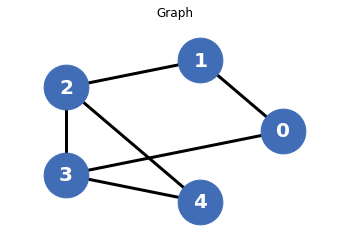

In [2]:
n = 5
nodes = list(range(n))
edges = [[0, 1], [1, 2], [2, 3], [3, 4], [0, 3], [2, 4]]
# 内置的画图函数可以打印生成的图G
draw_graph(nodes, edges)

In [3]:
def maxcut_hamiltonian(edges):
    pauli_list = []
    for edge in edges:
        pauli_list.append([-1.0, "Z" + str(edge[0]), "Z" + str(edge[1])])
    hamiltonian = Hamiltonian(pauli_list)

    return hamiltonian

H = maxcut_hamiltonian(edges)

H.pauli_str

[[-1.0, 'Z0', 'Z1'],
 [-1.0, 'Z1', 'Z2'],
 [-1.0, 'Z2', 'Z3'],
 [-1.0, 'Z3', 'Z4'],
 [-1.0, 'Z0', 'Z3'],
 [-1.0, 'Z2', 'Z4']]

In [4]:
KEY = jrandom.PRNGKey(0)
qaoa_net_sample = QAOANet(n_qubits=n, p=1, hamiltonian=H, key=KEY)

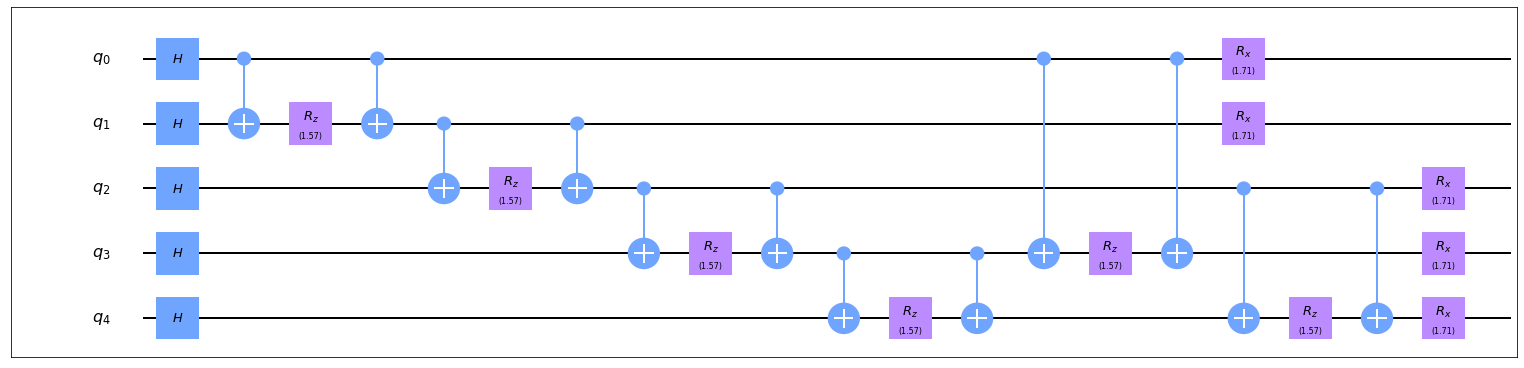

In [5]:
qaoa_cir_sample = qaoa_net_sample.construct_circuit()
qaoa_cir_sample.draw()

In [6]:
p = 4           # 量子电路层数
MAX_ITERS = 150 # 最大迭代次数
LR = 0.1        # 梯度下降的学习率
SEED = 17       # 随机数种子

set_seed(SEED)  # 设置全局随机种子

In [ ]:
qaoa_net = QAOANet(n_qubits=n, p=p, hamiltonian=H, key=KEY)

opt_init, opt_update, get_params = optimizers.adam(LR)

@jit
def update(i, opt_state, state):
    params = get_params(opt_state)
    return opt_update(i, grad(qaoa_net.loss_func)(state), opt_state)

# opt = optax.adam(LR)
# solver = OptaxSolver(opt=opt, fun=ridge_reg_objective, maxiter=MAX_ITERS)

# 开始训练
qaoa_net.train()
loader = tqdm.trange(MAX_ITERS, desc="Training", leave=True)
for it in loader:
    state = qaoa_net()
    loss = qaoa_net.loss_func(state)

    loader.set_postfix(loss=loss.item())